# 1. Pre-process data



In [1]:
!pip install transformers==3.0.2
!pip install nlp

     |████████████████████████████████| 778kB 18.1MB/s 
     |████████████████████████████████| 901kB 55.6MB/s 
     |████████████████████████████████| 3.0MB 55.3MB/s 
     |████████████████████████████████| 1.2MB 51.8MB/s 
     |████████████████████████████████| 1.7MB 31.2MB/s 
     |████████████████████████████████| 245kB 51.9MB/s 


In [2]:

import gc
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nlp import load_dataset
from transformers import TFAutoModel, AutoTokenizer

import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Embedding, GlobalAveragePooling1D, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(123)

In [5]:
# load data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content//sample_submission.csv')

a. For train data

In [4]:
print("Training data shape: ", train.shape)
print("Traning data samples: ")
train.head(3)

Training data shape:  (12120, 6)
Traning data samples: 


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0


In [5]:
train['language'].value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
German         351
Turkish        351
Bulgarian      342
Name: language, dtype: int64

In [6]:
train.language.unique()

array(['English', 'French', 'Thai', 'Turkish', 'Urdu', 'Russian',
       'Bulgarian', 'German', 'Arabic', 'Chinese', 'Hindi', 'Swahili',
       'Vietnamese', 'Spanish', 'Greek'], dtype=object)

In [7]:
print("Total number of languages in train data: ",len(train.language.unique()))

Total number of languages in train data:  15


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


b. For test data

In [9]:
print("Testing data shape: ", test.shape)
print("Testing data samples: ")
test.head(3)

Testing data shape:  (5195, 5)
Testing data samples: 


,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French


In [10]:
test['language'].value_counts()

English       2945
Spanish        175
Russian        172
Swahili        172
Greek          168
Urdu           168
Turkish        167
Thai           164
Arabic         159
French         157
German         152
Chinese        151
Hindi          150
Bulgarian      150
Vietnamese     145
Name: language, dtype: int64

In [11]:
test.language.unique()

array(['Urdu', 'Arabic', 'French', 'Chinese', 'Russian', 'English',
       'Swahili', 'German', 'Greek', 'Turkish', 'Hindi', 'Vietnamese',
       'Spanish', 'Bulgarian', 'Thai'], dtype=object)

In [12]:
print("Total number of languages in test data: ",len(test.language.unique()))

Total number of languages in test data:  15


In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


2. Perform data exploration

a. For train data

In [ ]:
train['label_str'] = train['label'].map({0 : "entailment", 1 : "neutral", 2 : "contradiction"})

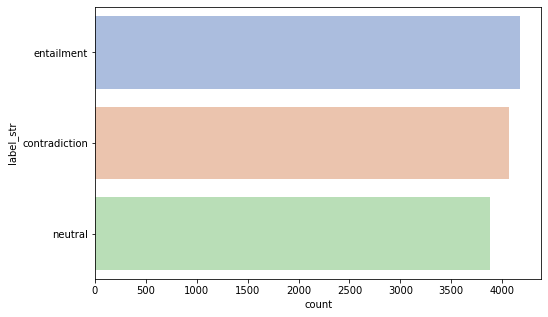

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(y ='label_str', data = train, alpha=.5, palette="muted")

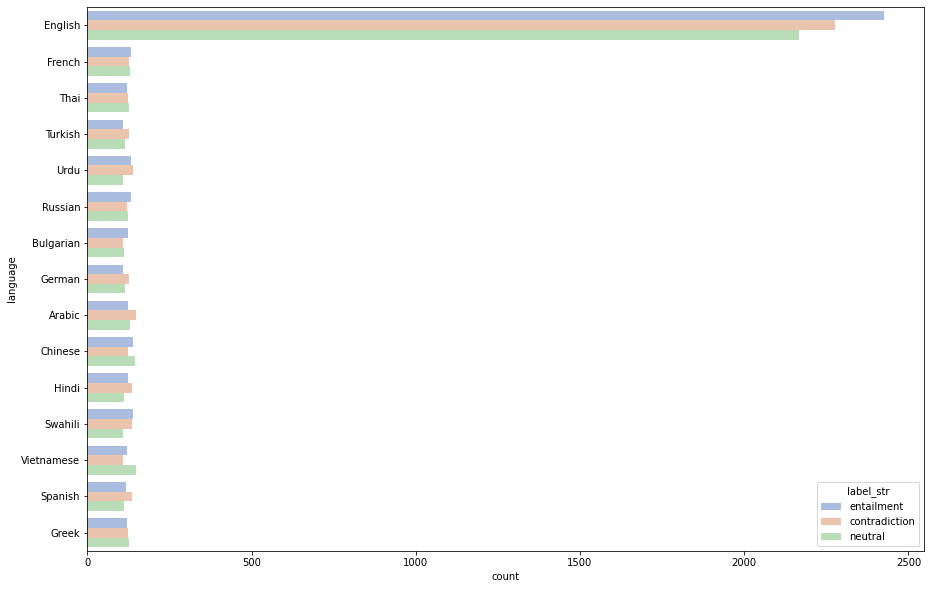

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(y ='language', hue = "label_str", data = train, alpha=.5, palette="muted")

# 3. Use sequence2sequence to build the model

In [6]:
for i in range(len(train['id'])):
  if train['language'][i] != "English":
    train = train.drop(i, axis = 0)
new_id = [i for i in range(len(train['id']))]
train.index = new_id
print("Length of data: ", len(train['id']))
train.head(10)

Length of data:  6870


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1
5,dd4f0d9f25,"""If you people only knew how fatally easy it i...",Many people have poisoned someone by mistake.,en,English,1
6,0a3f52c547,"My own little corner of the world, policy wonk...",An example is policy wonking.,en,English,0
7,4b0eca3ccb,life in prison then he's available for parole ...,The system is corrupt because he won't be able...,en,English,1
8,cad235551c,The streets are crammed with vendors selling s...,Vendors have lined the streets with torches an...,en,English,2
9,d8b3a4fb06,"North of Mytilini, stop at the village of Mori...",There is nothing special to see in the village...,en,English,2


In [7]:
import spacy
import re
import nltk
#instantiating English module
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 10000
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
documents = []
stemmer = WordNetLemmatizer()
# combine two sentences into one
combine_sentences = []
for i in range(len(train['id'])):
    sentences = str(train['premise'][i]) + " " + str(train['hypothesis'][i])
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(sentences))
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    # Converting to Lowercase
    document = document.lower()
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    document = [document]
    combine_sentences.append(document)
train["combined"] = combine_sentences
train.head(5)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


,id,premise,hypothesis,lang_abv,language,label,combined
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comment were considered in formulat...
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[these are issue that we wrestle with in pract...
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can really defend themselves li...
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2,[from cockpit country to st ann bay from st an...
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,[look it your skin but you re going to be in t...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
tfidfconverter = TfidfVectorizer(max_features=2)
# tfidfconverter = TfidfVectorizer()
vector_tfdif = []
for i in range(len(train["combined"])):
    input_value = train["combined"][i]
    # print(input_value, i)
    test_vec = tfidfconverter.fit_transform(input_value).toarray()
    vector_tfdif.append(test_vec[0])
print(len(vector_tfdif))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
6870


In [9]:
train["vector_tfdif"] = vector_tfdif
vector_tfdif_array = np.array(vector_tfdif)
print(vector_tfdif_array.shape)
train.head(10)

(6870, 2)


,id,premise,hypothesis,lang_abv,language,label,combined,vector_tfdif
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comment were considered in formulat...,"[0.7071067811865476, 0.7071067811865476]"
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[these are issue that we wrestle with in pract...,"[0.7071067811865475, 0.7071067811865475]"
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can really defend themselves li...,"[0.7071067811865475, 0.7071067811865475]"
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2,[from cockpit country to st ann bay from st an...,"[0.7071067811865475, 0.7071067811865475]"
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,[look it your skin but you re going to be in t...,"[0.4472135954999579, 0.8944271909999159]"
5,dd4f0d9f25,"""If you people only knew how fatally easy it i...",Many people have poisoned someone by mistake.,en,English,1,[if you people only knew how fatally easy it i...,"[0.7071067811865475, 0.7071067811865475]"
6,0a3f52c547,"My own little corner of the world, policy wonk...",An example is policy wonking.,en,English,0,[my own little corner of the world policy wonk...,"[0.7071067811865475, 0.7071067811865475]"
7,4b0eca3ccb,life in prison then he's available for parole ...,The system is corrupt because he won't be able...,en,English,1,[life in prison then he available for parole i...,"[0.7071067811865476, 0.7071067811865476]"
8,cad235551c,The streets are crammed with vendors selling s...,Vendors have lined the streets with torches an...,en,English,2,[the street are crammed with vendor selling sh...,"[0.8320502943378437, 0.5547001962252291]"
9,d8b3a4fb06,"North of Mytilini, stop at the village of Mori...",There is nothing special to see in the village...,en,English,2,[north of mytilini stop at the village of mori...,"[0.8, 0.6]"


In [10]:
from keras.utils import to_categorical

X_tfdif, y_tfdif = train['vector_tfdif'].values.tolist(), train['label'].values.tolist()
X_tfdif = np.array(X_tfdif)
y_tfdif = np.array(y_tfdif)
y_tfdif = to_categorical(y_tfdif, 3)
print("Length of data: ", X_tfdif.shape)
print("Length of label: ", y_tfdif.shape)

X_train_tfdif, X_test_tfdif, Y_train_tfdif, Y_test_tfdif = train_test_split(X_tfdif, y_tfdif, test_size=0.2, random_state=1)
print("Shape of train data: ", X_train_tfdif.shape,Y_train_tfdif.shape)
print("Shape of test data: ", X_test_tfdif.shape,Y_test_tfdif.shape)

Length of data:  (6870, 2)
Length of label:  (6870, 3)
Shape of train data:  (5496, 2) (5496, 3)
Shape of test data:  (1374, 2) (1374, 3)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          100000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
Total params: 163,135
Trainable params: 163,135
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
86/86 [==============================] - 34s 6ms/step - loss: 0.6653 - accuracy: 0.3336
Epoch 2/15
8

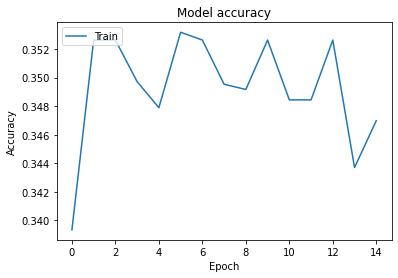

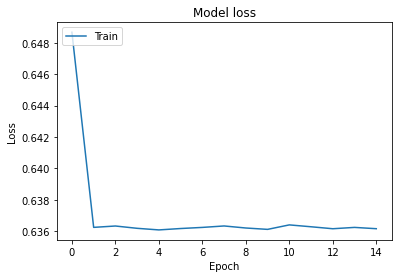

In [11]:
top_words = 1000
max_review_length = 500
embedding_vecor_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

EPOCHS = 15
BATCH_SIZE = 64
history_se2se = model.fit(X_train_tfdif, Y_train_tfdif, epochs=EPOCHS, batch_size=BATCH_SIZE)
# Final evaluation of the model
scores = model.evaluate(X_test_tfdif, Y_test_tfdif, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

plt.plot(history_se2se.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_se2se.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_tfdif)
final_1 = np.argmax(y_pred, axis = 1)    
Y_test_tfdif_1 = np.argmax(Y_test_tfdif, axis = 1)
print(classification_report(Y_test_tfdif_1, final_1))

              precision    recall  f1-score   support

           0       0.36      1.00      0.52       489
           1       0.00      0.00      0.00       444
           2       0.00      0.00      0.00       441

    accuracy                           0.36      1374
   macro avg       0.12      0.33      0.17      1374
weighted avg       0.13      0.36      0.19      1374



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


* Using word2vec

In [13]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# load the google word2vec model
filename = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'
model_word2vec = KeyedVectors.load_word2vec_format(filename, binary=True, limit = 300000)

In [14]:
# get new data for using word2vec
train_word2vec = train
train_word2vec.head(5)

,id,premise,hypothesis,lang_abv,language,label,combined,vector_tfdif
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comment were considered in formulat...,"[0.7071067811865476, 0.7071067811865476]"
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[these are issue that we wrestle with in pract...,"[0.7071067811865475, 0.7071067811865475]"
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can really defend themselves li...,"[0.7071067811865475, 0.7071067811865475]"
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2,[from cockpit country to st ann bay from st an...,"[0.7071067811865475, 0.7071067811865475]"
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,[look it your skin but you re going to be in t...,"[0.4472135954999579, 0.8944271909999159]"


In [15]:
#importing libraries
import spacy
import datetime
start_time = datetime.datetime.now()
#instantiating English module
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 10000
word2vec_data = []
for i in range(len(train_word2vec["combined"])):
    #creating doc object containing our token features
    doc = nlp(train_word2vec["combined"][i][0])

    #Creating and updating our list of tokens using list comprehension 
    tokens = [token.text for token in doc]
    word2vec_data.append(tokens)
print("Length of word2vec_data: ", len(word2vec_data))
stop_time = datetime.datetime.now()
cost_time = (stop_time-start_time)
total_seconds = cost_time.total_seconds()
print("Cost time for using spacy step", total_seconds)

Length of word2vec_data:  6870
Cost time for using spacy step 280.814229


In [16]:
train_word2vec["spacy_data"] = word2vec_data
train_word2vec.head(5)

,id,premise,hypothesis,lang_abv,language,label,combined,vector_tfdif,spacy_data
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comment were considered in formulat...,"[0.7071067811865476, 0.7071067811865476]","[and, these, comment, were, considered, in, fo..."
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[these are issue that we wrestle with in pract...,"[0.7071067811865475, 0.7071067811865475]","[these, are, issue, that, we, wrestle, with, i..."
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can really defend themselves li...,"[0.7071067811865475, 0.7071067811865475]","[you, know, they, can, really, defend, themsel..."
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2,[from cockpit country to st ann bay from st an...,"[0.7071067811865475, 0.7071067811865475]","[from, cockpit, country, to, st, ann, bay, fro..."
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,[look it your skin but you re going to be in t...,"[0.4472135954999579, 0.8944271909999159]","[look, it, your, skin, but, you, re, going, to..."


In [17]:
import numpy as np
word2vec_data_vec = []
for j in range(len(train_word2vec["spacy_data"])):
    vec = []
    for i in range(len(train_word2vec["spacy_data"][j])):
        if word2vec_data[j][i] in model_word2vec.vocab:
            a = np.array(model_word2vec.get_vector(word2vec_data[j][i]))
            vec.append(a)
    vec = np.array(vec)
    vec_average = np.average(vec, axis=0)
    word2vec_data_vec.append(vec_average)
print("Length of word2vec_data_vec: ", len(word2vec_data_vec))

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Length of word2vec_data_vec:  6870


In [18]:
nan_index = []
for i in range(len(word2vec_data_vec)):
  if str(word2vec_data_vec[i]) == "nan":
    print(word2vec_data_vec[i], i)
    nan_index.append(i)
print("All nan index: ", nan_index)

nan 110
nan 446
All nan index:  [110, 446]


In [19]:
word2vec_data_vec = [i for j, i in enumerate(word2vec_data_vec) if j not in nan_index]

for i in range(len(nan_index)):
  train_word2vec = train_word2vec.drop(nan_index[i], axis = 0)

print("Length of data after: ", len(word2vec_data_vec), len(train_word2vec["spacy_data"]))

new_id = [i for i in range(len(train_word2vec['id']))]
train_word2vec.index = new_id

train_word2vec["word2vec_vector"] = word2vec_data_vec
train_word2vec.head(5)

Length of data after:  6868 6868


,id,premise,hypothesis,lang_abv,language,label,combined,vector_tfdif,spacy_data,word2vec_vector
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,[and these comment were considered in formulat...,"[0.7071067811865476, 0.7071067811865476]","[and, these, comment, were, considered, in, fo...","[-0.04960566, 0.04010275, 0.043578107, 0.02746..."
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,[these are issue that we wrestle with in pract...,"[0.7071067811865475, 0.7071067811865475]","[these, are, issue, that, we, wrestle, with, i...","[0.007223378, 0.014515752, 0.004139776, 0.0947..."
2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,[you know they can really defend themselves li...,"[0.7071067811865475, 0.7071067811865475]","[you, know, they, can, really, defend, themsel...","[0.091822304, 0.056259155, 0.0060011544, 0.133..."
3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2,[from cockpit country to st ann bay from st an...,"[0.7071067811865475, 0.7071067811865475]","[from, cockpit, country, to, st, ann, bay, fro...","[-0.026529947, 0.078828335, -0.007405599, -0.0..."
4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,[look it your skin but you re going to be in t...,"[0.4472135954999579, 0.8944271909999159]","[look, it, your, skin, but, you, re, going, to...","[0.07044161, 0.05802147, 0.029787503, 0.140671..."


In [20]:
from keras.utils import to_categorical

X_w2v, y_w2v = train_word2vec['word2vec_vector'].values.tolist(), train_word2vec['label'].values.tolist()
X_w2v = np.array(X_w2v)
y_w2v = np.array(y_w2v)
y_w2v = to_categorical(y_w2v, 3)
print("Length of data: ", X_w2v.shape)
print("Length of label: ", y_w2v.shape)

X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.2, random_state=1)
print("Shape of train data: ", X_train_w2v.shape,Y_train_w2v.shape)
print("Shape of test data: ", X_test_w2v.shape,Y_test_w2v.shape)

Length of data:  (6868, 300)
Length of label:  (6868, 3)
Shape of train data:  (5494, 300) (5494, 3)
Shape of test data:  (1374, 300) (1374, 3)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          300000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 382,335
Trainable params: 382,335
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
86/86 [==============================] - 4s 29ms/step - loss: 0.6498 - accuracy: 0.3259
Epoch 2/15

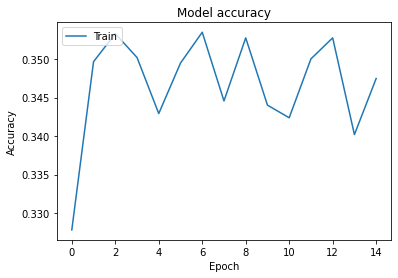

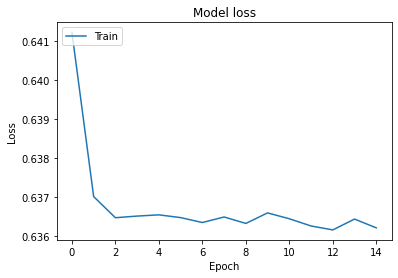

In [21]:
top_words = 1000
max_review_length = 300
embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

EPOCHS = 15
BATCH_SIZE = 64
history_se2se = model.fit(X_train_w2v, Y_train_w2v, epochs=EPOCHS, batch_size=BATCH_SIZE)
# Final evaluation of the model
scores = model.evaluate(X_test_w2v, Y_test_w2v, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

plt.plot(history_se2se.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_se2se.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import classification_report
y_pred_1 = model.predict(X_test_w2v)
final_2 = np.argmax(y_pred_1, axis = 1)    
Y_test_w2v_1 = np.argmax(Y_test_w2v, axis = 1)
print(classification_report(Y_test_w2v_1, final_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       488
           1       0.00      0.00      0.00       444
           2       0.32      1.00      0.49       442

    accuracy                           0.32      1374
   macro avg       0.11      0.33      0.16      1374
weighted avg       0.10      0.32      0.16      1374



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4. Use BERT to build the model

## *** Prepare data for training(BERT)

In [23]:
# prepare data for training and testing
total_train = train.drop(columns=['id'])
shuffled_data = shuffle(total_train).reset_index(drop = True)
X, y = shuffled_data[['premise', 'hypothesis']].values.tolist(), shuffled_data['label']
print("Length of data: ", len(X))
print("Length of label: ", len(y))

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2020)
print("Length of train data: ", len(x_train))
print("Length of train label: ", len(y_train))

print("Length of valid data: ", len(x_valid))
print("Length of valid label: ", len(y_valid))

print("Example of x_train data: ", x_train[0])
print("Example of y_train data: ", y_train[0])

Length of data:  6870
Length of label:  6870
Length of train data:  5152
Length of train label:  5152
Length of valid data:  1718
Length of valid label:  1718
Example of x_train data:  ['well the channel eight when they came here thirteen fourteen years ago Dave Fox and Tracy Rowlett came together uh from Oklahoma City and apparently channel eight was way down and now they have turned it all around and done a pretty remarkable job and then', "We don't have a Channel 8."]
Example of y_train data:  2


In [24]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [25]:
MODEL = 'joeddav/xlm-roberta-large-xnli'

EPOCHS = 4
MAXLEN = 120

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

tokenizer = AutoTokenizer.from_pretrained(MODEL)
auto = tf.data.experimental.AUTOTUNE

In [27]:
def create_model(transformer_layer,learning_rate):
    input_ids = Input(shape = (MAXLEN,), dtype = tf.int32)
    #input_masks = Input(shape = (MAXLEN,), dtype = tf.int32)

    #insert roberta layer
    roberta = TFAutoModel.from_pretrained(transformer_layer)
    roberta = roberta([input_ids])[0]

    out = GlobalAveragePooling1D()(roberta)

    #add our softmax layer
    out = Dense(3, activation = 'softmax')(out)

    #assemble model and compile
    model = Model(inputs = input_ids, outputs = out)
    model.compile(
                    optimizer = Adam(lr = learning_rate), 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])
    return model


def tokeniZer(text,tokenizer):
    # tokenize
    encoded = tokenizer.batch_encode_plus(text, padding=True, max_length=MAXLEN, truncation=True)

    return np.array(encoded['input_ids'])

In [28]:
x_train_token = tokeniZer(x_train,tokenizer)
x_valid_token = tokeniZer(x_valid,tokenizer)
x_test_token  = tokeniZer(test[['premise', 'hypothesis']].values.tolist(),tokenizer)

In [29]:
print("x_train example after using xlm model: ", len(x_train_token[0]), '\n', x_train_token[0])

x_train example after using xlm model:  120 
 [     0   5299     70  86723 136659   3229   1836  21449   3688      6
  95037   8927  22759   8927   5369   6650 103383  49049    136   4937
   2408  96190  37356  21449  25842  38074   1295 238215   6406    136
 198371  86723 136659    509   3917   7565    136   5036   1836    765
  69347    442    756  10932    136  16940     10  28875    456  10015
   2886  12447    136   7068      2      2   1401   2301     25     18
    765     10  55969   3217      2      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1
      1      1      1      1      1      1      1      1      1      1]


In [30]:
# datasets
def build_dataset(x, y, mode, batch_size):
    if mode == "train":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .repeat()
            .shuffle(2048)
            .batch(batch_size)
            .prefetch(auto)
        )
    elif mode == "valid":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(auto)
        )
    elif mode == "test":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices(x)
            .batch(BATCH_SIZE)
        )
    else:
        raise NotImplementedError
    return dataset

In [31]:
train_dataset = build_dataset(x_train_token, y_train, "train", BATCH_SIZE)
valid_dataset = build_dataset(x_valid_token, y_valid, "valid", BATCH_SIZE)
test_dataset  = build_dataset(x_test_token, None, "test", BATCH_SIZE)

In [32]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((None, 120), (None,)), types: (tf.int64, tf.int64)>
<PrefetchDataset shapes: ((None, 120), (None,)), types: (tf.int64, tf.int64)>
<BatchDataset shapes: (None, 120), types: tf.int64>


In [33]:
def create_xlm(transformer_layer, random_seed, learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    with strategy.scope():
        model = create_model(transformer_layer,learning_rate)
    model.summary()    
    return model

In [34]:
Xlm = create_xlm(MODEL,1124234,1e-5)

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 120, 1024), (None 559890432 
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


In [35]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, 
                                              monitor = 'val_loss', 
                                              restore_best_weights = True, 
                                              mode = 'min')]

steps_per_epoch = len(x_train) // BATCH_SIZE
# history_xlm = Xlm.fit(train_dataset,
#                       validation_data=valid_dataset,
#                       steps_per_epoch=steps_per_epoch,
#                       epochs = EPOCHS)

history_xlm = Xlm.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch=steps_per_epoch,
                      epochs = EPOCHS,
                      callbacks = callbacks)

Epoch 1/4
322/322 [==============================] - 505s 1s/step - loss: 0.4811 - accuracy: 0.8108 - val_loss: 0.3477 - val_accuracy: 0.8807
Epoch 2/4
322/322 [==============================] - 484s 2s/step - loss: 0.2265 - accuracy: 0.9235 - val_loss: 0.4280 - val_accuracy: 0.8749
Epoch 3/4
322/322 [==============================] - 485s 2s/step - loss: 0.1164 - accuracy: 0.9607 - val_loss: 0.5113 - val_accuracy: 0.8719


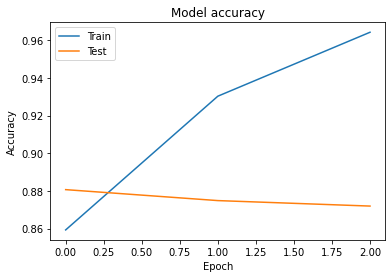

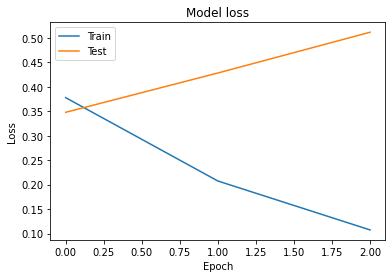

In [36]:
plt.plot(history_xlm.history['accuracy'])
plt.plot(history_xlm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_xlm.history['loss'])
plt.plot(history_xlm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [40]:
from sklearn.metrics import classification_report
y_pred_2 = Xlm.predict(valid_dataset)
final_3 = np.argmax(y_pred_2, axis = 1)    
y_valid_1 = y_valid.values
print(classification_report(y_valid_1, final_3))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       621
           1       0.88      0.79      0.84       542
           2       0.89      0.92      0.91       555

    accuracy                           0.88      1718
   macro avg       0.88      0.88      0.88      1718
weighted avg       0.88      0.88      0.88      1718

